In [5]:
import pymongo 
import pprint
mongo_uri = "mongodb://localhost:27017/"  
client = pymongo.MongoClient(mongo_uri)

mydb=client.TestB
mydb.list_collection_names()

mycoll=mydb.cancer_data

import pandas as pd
samples=mycoll.find().sort("_id",pymongo.DESCENDING)[:116]
df=pd.DataFrame(samples)


df.to_csv('B:/soft/cygdrive/py/FILES/nosql/Data_Can.csv',index=False)

In [2]:
import os
import sys
spark_path = r"C:/spark-2.4.5-bin-hadoop2.7" # spark installed folder
os.environ['SPARK_HOME'] = spark_path
sys.path.insert(0, spark_path + "/bin")
sys.path.insert(0, spark_path + "/python/pyspark/")
sys.path.insert(0, spark_path + "/python/lib/pyspark.zip")
sys.path.insert(0, spark_path + "/python/lib/py4j-0.10.7-src.zip")



from pyspark.sql import SparkSession
import pyspark.sql as sparksql
spark = SparkSession.builder.appName('cancer').getOrCreate()
train = spark.read.csv('C:/Users/pkdut/Downloads/anac_proj/Data_Can.csv', inferSchema=True,header=True)
test = spark.read.csv('C:/Users/pkdut/Downloads/anac_proj/Test_can.csv', inferSchema=True,header=True)


In [8]:
train.groupBy('Classification').count().show()

+--------------+-----+
|Classification|count|
+--------------+-----+
|             1|    3|
|             0|  113|
+--------------+-----+



In [3]:
train.createOrReplaceTempView('table')

In [12]:
spark.sql("SELECT work_type, COUNT(work_type) as work_type_count FROM table WHERE Classification == 1 GROUP BY work_type ORDER BY COUNT(work_type) DESC").show()
spark.sql("SELECT work_type, COUNT(work_type) as work_type_count FROM table WHERE Classification == 0 GROUP BY work_type ORDER BY COUNT(work_type) DESC").show()

+-------------+---------------+
|    work_type|work_type_count|
+-------------+---------------+
|      Private|              2|
|Self-employed|              1|
+-------------+---------------+

+-------------+---------------+
|    work_type|work_type_count|
+-------------+---------------+
|      Private|             59|
|     children|             24|
|     Govt_job|             16|
|Self-employed|             14|
+-------------+---------------+



In [14]:
spark.sql("SELECT gender, COUNT(gender) as gender_count, COUNT(gender)*100/(SELECT COUNT(gender) FROM table WHERE gender == 'Male') as percentage FROM table WHERE Classification== 1 AND gender = 'Male' GROUP BY gender").show()
spark.sql("SELECT gender, COUNT(gender) as gender_count, COUNT(gender)*100/(SELECT COUNT(gender) FROM table WHERE gender == 'Female') as percentage FROM table WHERE Classification== 1 AND gender = 'Female' GROUP BY gender").show()


+------+------------+------------------+
|gender|gender_count|        percentage|
+------+------------+------------------+
|  Male|           1|1.8181818181818181|
+------+------------+------------------+

+------+------------+-----------------+
|gender|gender_count|       percentage|
+------+------------+-----------------+
|Female|           2|3.278688524590164|
+------+------------+-----------------+



In [9]:
spark.sql("SELECT COUNT(age)*100/(SELECT COUNT(age) FROM table WHERE Classification ==0) as percentage FROM table WHERE Classification == 1 AND age>=50").show()

+------------------+
|        percentage|
+------------------+
|2.6548672566371683|
+------------------+



In [43]:
# As this is categorical data, we will add one data type "No Info" for the missing one
train_f = train.na.fill('No Info', subset=['smoking_status'])
test_f = test.na.fill('No Info', subset=['smoking_status'])

In [44]:
# as this is numecial data , we will simple fill the missing values with mean
from pyspark.sql.functions import mean
mean = train_f.select(mean(train_f['bmi'])).collect()
mean_bmi = mean[0][0]
train_f = train_f.na.fill(mean_bmi,['bmi'])
test_f = test_f.na.fill(mean_bmi,['bmi'])

In [21]:
from pyspark.ml.feature import StringIndexer
indexer1 = StringIndexer(inputCol="gender", outputCol="genderIndex")
indexer2 = StringIndexer(inputCol="ever_married", outputCol="ever_marriedIndex")
indexer3 = StringIndexer(inputCol="work_type", outputCol="work_typeIndex")
indexer4 = StringIndexer(inputCol="Residence_type", outputCol="Residence_typeIndex")
indexer5 = StringIndexer(inputCol="smoking_status", outputCol="smoking_statusIndex")

In [22]:
from pyspark.ml.feature import OneHotEncoderEstimator
encoder = OneHotEncoderEstimator(inputCols=["genderIndex","ever_marriedIndex","work_typeIndex","Residence_typeIndex","smoking_statusIndex"],
                                 outputCols=["genderVec","ever_marriedVec","work_typeVec","Residence_typeVec","smoking_statusVec"])

In [28]:
from pyspark.ml.feature import VectorAssembler
assembler = VectorAssembler(inputCols=['genderVec',
 'age',
 'hypertension',
 'ever_marriedVec',
 'work_typeVec',
 'Residence_typeVec',
 'avg_glucose_level',
 'bmi',
 'smoking_statusVec'],outputCol='features')

In [29]:
from pyspark.ml.classification import DecisionTreeClassifier
dtc = DecisionTreeClassifier(labelCol='Classification',featuresCol='features')

In [30]:
from pyspark.ml import Pipeline
pipeline = Pipeline(stages=[indexer1, indexer2, indexer3, indexer4, indexer5, encoder, assembler, dtc])

In [32]:
# splitting training and validation data
train_data,val_data = train_f.randomSplit([0.7,0.3])

# training model pipeline with data
model = pipeline.fit(train_data)

In [34]:
dtc_predictions = model.transform(val_data)

# Select example rows to display.
dtc_predictions.select("prediction","probability", "Classification", "features").show(5)

+----------+-----------+--------------+--------------------+
|prediction|probability|Classification|            features|
+----------+-----------+--------------+--------------------+
|       0.0|  [1.0,0.0]|             0|(13,[1,3,4,7,8,9,...|
|       0.0|  [1.0,0.0]|             0|(13,[0,1,4,7,8,9,...|
|       0.0|  [1.0,0.0]|             0|(13,[1,3,7,8,9,12...|
|       0.0|  [1.0,0.0]|             1|(13,[1,3,7,8,9,10...|
|       0.0|  [1.0,0.0]|             0|(13,[1,6,7,8,9,10...|
+----------+-----------+--------------+--------------------+
only showing top 5 rows



In [35]:
import pandas as pd
df=pd.DataFrame(train_data.take(5), columns=train_data.columns).transpose()

In [36]:
train_data.describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
_id,90,None,None,5eb17b72a6a5fe6e71e0857b,5eb17b72a6a5fe6e71e085ed
id,90,36230.055555555555,20308.59850516697,1413,71510
gender,90,None,None,Female,Male
age,90,41.36,24.285586977288826,0.56,82.0
hypertension,90,0.05555555555555555,0.23034469096157234,0,1
ever_married,90,None,None,No,Yes
work_type,90,None,None,Govt_job,children
Residence_type,90,None,None,Rural,Urban
avg_glucose_level,90,101.45833333333329,42.221322060267774,55.03,248.93


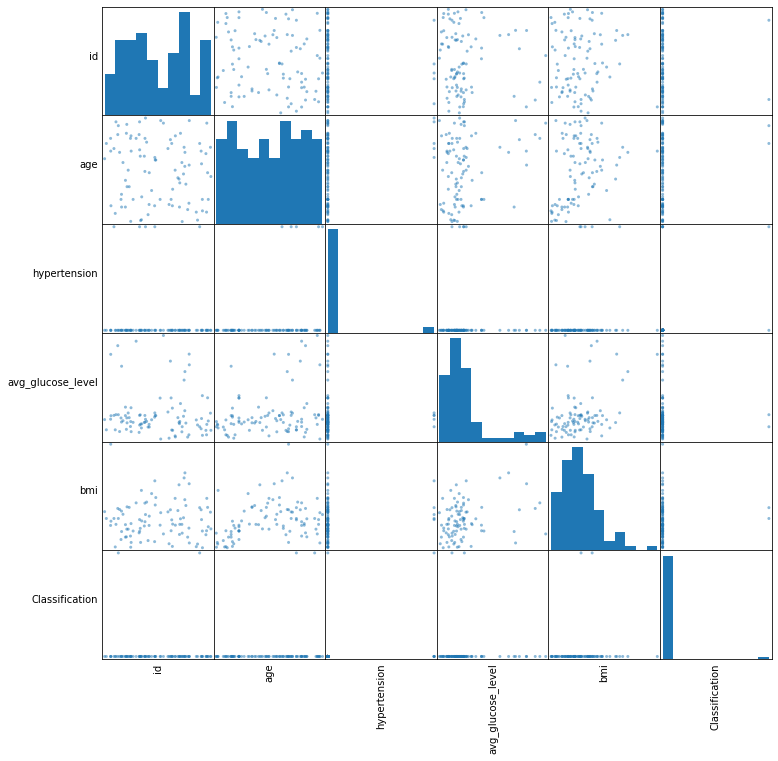

In [37]:
import matplotlib.pyplot as plt
# Correlation analysis
numeric_features = [t[0] for t in
 train_data.dtypes if t[1] == "int" or t[1]== "double"]
sample_d=train_data.select(numeric_features) \
.sample(False,1.0).toPandas()

axs = pd.plotting.scatter_matrix(sample_d, figsize=(12, 12))
# Rotate axis labels and remove axis ticks
n = len(sample_d.columns)
for i in range(n):
 v = axs[i, 0]
 v.yaxis.label.set_rotation(0)
 v.yaxis.label.set_ha('right')
 v.set_yticks(())
 h = axs[n-1, i]
 h.xaxis.label.set_rotation(90)
 h.set_xticks(())
#Show the data plotting
plt.show()


In [39]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Select (prediction, true label) and compute test error
acc_evaluator = MulticlassClassificationEvaluator(labelCol="Classification", predictionCol="prediction", metricName="accuracy")
acc_evaluator1 = MulticlassClassificationEvaluator(labelCol="Classification", predictionCol="prediction", metricName="f1")
acc_evaluator2 = BinaryClassificationEvaluator( rawPredictionCol="prediction",labelCol="Classification", metricName="areaUnderROC")
dtc_acc = acc_evaluator.evaluate(dtc_predictions)
dtc_acc1 = acc_evaluator1.evaluate(dtc_predictions)
dtc_acc2 = acc_evaluator2.evaluate(dtc_predictions)
print('A Decision Tree algorithm had an accuracy of: {0:2.2f}%'.format(dtc_acc*100))
print('A Decision Tree algorithm had an accuracy of: {0:2.2f}%'.format(dtc_acc1*100))
print('A Decision Tree algorithm had an accuracy of: {0:2.2f}%'.format(dtc_acc2*100))

A Decision Tree algorithm had an accuracy of: 92.31%
A Decision Tree algorithm had an accuracy of: 92.31%
A Decision Tree algorithm had an accuracy of: 48.00%


In [45]:
# now predicting the labels for test data
test_pred = model.transform(test_f)
test_selected = test_pred.select("id", "features", "prediction","probability","Classification")
test_selected.limit(5).toPandas()


,id,features,prediction,probability,Classification
0,36271,"(0.0, 82.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 79.4...",0.0,"[1.0, 0.0]",0
1,27973,"[1.0, 40.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 99.1...",0.0,"[1.0, 0.0]",0
2,5450,"(0.0, 56.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 213....",0.0,"[1.0, 0.0]",0
3,28375,"[0.0, 82.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 91.9...",0.0,"[1.0, 0.0]",0
4,56196,"(0.0, 10.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 58.6...",0.0,"[1.0, 0.0]",0


In [46]:
train .groupby('Classification').count().toPandas()


,Classification,count
0,1,3
1,0,113


In [48]:
satisfied_dataset_all = train.sampleBy('Classification',fractions={0: 1.0, 1:3/113}).cache()


In [49]:
satisfied_dataset_all .groupby('Classification').count().toPandas()


,Classification,count
0,0,113


In [50]:
evaluator = BinaryClassificationEvaluator(labelCol="Classification", rawPredictionCol="probability")
evaluator.evaluate(test_pred)


0.8289085545722713

In [55]:
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
paramGrid = ParamGridBuilder().addGrid(dtc.maxDepth,[1,2,3,4,5,6]).build()
# Set up 3-fold cross validation
crossval = CrossValidator(estimator=pipeline,estimatorParamMaps=paramGrid, evaluator=evaluator,numFolds=3)
CV_model = crossval.fit(train_data)
tree_model = CV_model.bestModel.stages[1]
print(tree_model)

StringIndexer_29f0c2bb534f


In [52]:
predictions_improved = CV_model.bestModel.transform(val_data)
predictions_improved.select("id", "features", "prediction","probability","Classification").toPandas().head(25)

,id,features,prediction,probability,Classification
0,67563,"(0.0, 43.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 132....",0.0,"[0.9882352941176471, 0.011764705882352941]",0
1,39620,"(1.0, 22.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 89.4...",0.0,"[0.9882352941176471, 0.011764705882352941]",0
2,44188,"(0.0, 67.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 161....",0.0,"[0.9882352941176471, 0.011764705882352941]",0
3,35057,"(0.0, 80.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 75.9...",0.0,"[0.9882352941176471, 0.011764705882352941]",1
4,5868,"(0.0, 27.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 77.5...",0.0,"[0.9882352941176471, 0.011764705882352941]",0
5,72415,"(0.0, 22.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 95.3...",0.0,"[0.9882352941176471, 0.011764705882352941]",0
6,68126,"(1.0, 1.32, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 112....",0.0,"[0.9882352941176471, 0.011764705882352941]",0
7,37620,"(0.0, 23.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 95.6...",0.0,"[0.9882352941176471, 0.011764705882352941]",0
8,17698,"(0.0, 17.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 95.3...",0.0,"[0.9882352941176471, 0.011764705882352941]",0
9,70041,"(1.0, 18.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 76.2...",0.0,"[0.9882352941176471, 0.011764705882352941]",0


In [56]:
evaluator.evaluate(predictions_improved)

0.52